In [126]:
%matplotlib inline
import sys
import xarray as xr
import numpy as np
import os
import glob
import yaml
import math
from datetime import datetime, timedelta
from parcels import FieldSet, Field, VectorField, ParticleSet, JITParticle, ParcelsRandom, Variable
import matplotlib.pyplot as plt
from cartopy import crs, feature

sys.path.append('/home/jvalenti/MOAD/analysis-jose/Source')

from OP_functions import *
import cmocean
cmap = cmocean.cm.deep

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)


In [135]:
path = {'NEMO': '/results2/SalishSea/nowcast-green.202111/',
'coords': '/ocean/jvalenti/MOAD/grid/coordinates_seagrid_SalishSea201702.nc',
'coordsWW3': '/ocean/jvalenti/MOAD/grid2/WW3_grid.nc',
'mask': '/ocean/jvalenti/MOAD/grid2/mesh_mask202108_TDV.nc',
'bat': '/ocean/jvalenti/MOAD/grid/bathymetry_202108.nc',
'out': '/data/sallen/results',
'home': '/home/jvalenti/MOAD/analysis-jose/notebooks/parcels',
'anim': '/home/jvalenti/MOAD/animations'}


In [3]:
coords = xr.open_dataset(path['coords'], decode_times=False)
mask = xr.open_dataset(path['mask'])

In [4]:
def get_timestamps(start,length):
    timestamps=[]
    duration = timedelta(days=length)
    for day in range(duration.days):
        timestamps.append([start + timedelta(days=day)])
    return np.array(timestamps, dtype='datetime64')

def find_temp(rootdir):
    dirs=[]
    for file in os.listdir(rootdir):
        d = os.path.join(rootdir, file)
        if os.path.isdir(d):
            dirs.append(d)
    temp=sorted(dirs, key=lambda x: os.path.getctime(x), reverse=True)[:1][0]
    return temp[-12:]

def newest(path):
    files = os.listdir(path)
    paths = [os.path.join(path, basename) for basename in files]
    return max(paths, key=os.path.getctime)


In [117]:
#Definitions
start = datetime(2022, 2, 23) #Start date
length = 14 # Set Time length [days] 
dt = 90 #toggle between - or + to pick backwards or forwards 
N = 50 # 1000   # number of particles per location
n = 30
dmin = 0 #minimum depth
dd = 100 #max depth difference from dmin
dtp = 0
odt = 1 #mins
rrr = 1e3

In [118]:
#Set deploy coordinates following yaml  
Victoria_sill_j = 178-1
Victoria_sill_i = np.arange(235, 302 + 1) - 1
print (coords.nav_lat[Victoria_sill_i[0], Victoria_sill_j].values,
      coords.nav_lon[Victoria_sill_i[0], Victoria_sill_j].values,
      coords.nav_lat[Victoria_sill_i[-1], Victoria_sill_j].values,
      coords.nav_lon[Victoria_sill_i[-1], Victoria_sill_j].values)

clat = [coords.nav_lat[Victoria_sill_i[0], Victoria_sill_j].values + 0.1, 
        coords.nav_lat[Victoria_sill_i[-1], Victoria_sill_j].values - 0.05]
clon = [coords.nav_lon[Victoria_sill_i[0], Victoria_sill_j].values, 
        coords.nav_lon[Victoria_sill_i[-1], Victoria_sill_j].values]

duration = timedelta(days=length)
#Set deploy locations

clat,clon = transect_deploy(clat,clon,N)
clon = clon[0] -clon + clon[0]

x_offset, y_offset, z = p_deploy(N,n,dmin,dd,rrr)

lon = np.zeros([N,n])
lat = np.zeros([N,n])
for i in range(N):
    lon[i,:]=(clon[i] + x_offset[i,:])
    lat[i,:]=(clat[i] + y_offset[i,:])

48.11955 -123.25796 48.385162 -123.480675


In [119]:
#Set start date time and the name of the output file
name = 'Test mixing vs advection'
daterange = [start+timedelta(days=i) for i in range(length)]
fn =  name + '_'.join(d.strftime('%Y%m%d')+'_2L' for d in [start, start+duration]) + '.zarr'
outfile = os.path.join(path['out'], fn)

In [120]:
#Set start date time and the name of the output file
name = 'Test only advection '
daterange = [start+timedelta(days=i) for i in range(length)]
fn =  name + '_'.join(d.strftime('%Y%m%d')+'_2L' for d in [start, start+duration]) + '.zarr'
outfile_nomix = os.path.join(path['out'], fn)

In [121]:
####BUILD FIELDS FOR SIMULATION######
local = 0

varlist=['U','V','W']
filenames,variables=filename_set(start,length,varlist)
dimensions = {'lon': 'glamf', 'lat': 'gphif', 'depth': 'depthw','time': 'time_counter'}
field_set=FieldSet.from_nemo(filenames, variables, dimensions, allow_time_extrapolation=True, chunksize='auto')

#Find file names and variable names ###'Diat','Flag'###
varlist=['US','VS','WL','R','T','S','ssh','Bathy','Kz','totdepth','Vol']
filenames,variables=filename_set(start,length,varlist)


#Add Vertical diffusivity coefficient field
dimensions = {'lon': 'glamt', 'lat': 'gphit', 'depth': 'depthw','time': 'time_counter'}
Kz = Field.from_netcdf(filenames['Kz'], variables['Kz'], dimensions,allow_time_extrapolation=True, chunksize='auto')
field_set.add_field(Kz)


#Add Bathymetry 2D field
dimensions = {'lon': 'glamt', 'lat': 'gphit'}
Bth = Field.from_netcdf(filenames['Bathy'], variables['Bathy'], dimensions,allow_time_extrapolation=True, chunksize='auto')
TD = Field.from_netcdf(filenames['totdepth'], variables['totdepth'], dimensions,allow_time_extrapolation=True, chunksize='auto')
field_set.add_field(Bth)
field_set.add_field(TD)

#Add SSH 
dimensions = {'lon': 'glamt', 'lat': 'gphit','time': 'time_counter'}
SSH = Field.from_netcdf(filenames['ssh'], variables['ssh'], dimensions,allow_time_extrapolation=True, chunksize='auto')
field_set.add_field(SSH)

####BUILD Particle typeN######
class MPParticle(JITParticle):    
    vvl_factor = Variable('fact', initial =  1)    
    wa = Variable('wa', initial =  0) 
    wm = Variable('wm', initial =  0) 
    status = Variable('status', initial =  1) 

In [122]:
pset = ParticleSet.from_list(field_set, MPParticle, lon=lon, lat=lat, depth=z,time=start+timedelta(hours=odt))
pset2 = ParticleSet.from_list(field_set, MPParticle, lon=lon, lat=lat, depth=z,time=start+timedelta(hours=odt))

In [123]:
def Advection(particle, fieldset, time): 
    if particle.status == 1:
        ssh = fieldset.sossheig[time, particle.depth, particle.lat, particle.lon] #SSH(t)
        sshn = fieldset.sossheig[time+particle.dt, particle.depth, particle.lat, particle.lon] #SSH(t+dt)
        td = fieldset.totaldepth[time, particle.depth, particle.lat, particle.lon]#Total_depth
        particle.fact = (1+ssh/td)
        VVL = (sshn-ssh)*particle.depth/td
        (u1, v1, w1) = fieldset.UVW[time, particle.depth, particle.lat, particle.lon]
        lon1 = particle.lon + u1*.5*particle.dt
        lat1 = particle.lat + v1*.5*particle.dt
        dep1 = particle.depth + w1*.5*particle.dt/particle.fact
        (u2, v2, w2) = fieldset.UVW[time + .5 * particle.dt, dep1, lat1, lon1]
        lon2 = particle.lon + u2*.5*particle.dt
        lat2 = particle.lat + v2*.5*particle.dt
        dep2 = particle.depth + w2*.5*particle.dt/particle.fact
        (u3, v3, w3) = fieldset.UVW[time + .5 * particle.dt, dep2, lat2, lon2]
        lon3 = particle.lon + u3*particle.dt
        lat3 = particle.lat + v3*particle.dt
        dep3 = particle.depth + w3*particle.dt/particle.fact
        (u4, v4, w4) = fieldset.UVW[time + particle.dt, dep3, lat3, lon3]
        wa = (w1 + 2*w2 + 2*w3 + w4) /6.
        particle.wa = wa* particle.dt
        particle_dlon = (u1 + 2*u2 + 2*u3 + u4) / 6. * particle.dt
        particle_dlat = (v1 + 2*v2 + 2*v3 + v4) / 6. * particle.dt
        particle_ddepth = particle.wa/particle.fact + VVL
        if particle_ddepth + particle.depth < 0:
            particle_ddepth = - (particle_ddepth+particle.depth)
    else:
        particle_dlon = 0
        particle_dlat = 0
        particle_ddepth = 0

def turb_mix(particle,fieldset,time):
    if particle.status==1:
        """Vertical mixing"""
        #Vertical mixing
        if particle.depth + 0.5/particle.fact > td: #Only calculate gradient of diffusion for particles deeper than 0.5 otherwise OP will check for particles outside the domain and remove it.
            Kzdz = 2*(fieldset.vert_eddy_diff[time, particle.depth, particle.lat, particle.lon]-fieldset.vert_eddy_diff[time, particle.depth-0.5/particle.fact, particle.lat, particle.lon]) #backwards difference 
        else: 
            Kzdz = 2*(fieldset.vert_eddy_diff[time, particle.depth+0.5/particle.fact, particle.lat, particle.lon]-fieldset.vert_eddy_diff[time, particle.depth, particle.lat, particle.lon]) #forward difference 
        dgrad = Kzdz*particle.dt/particle.fact
        if particle.depth+(0.5*dgrad) > 0 and particle.depth+(0.5*dgrad) < td:
            Kz = fieldset.vert_eddy_diff[time, particle.depth+ 0.5*dgrad, particle.lat, particle.lon] #Vertical diffusivity SSC  
        else:
            Kz = 0#fieldset.vert_eddy_diff[time, particle.depth, particle.lat, particle.lon] 

        Rr = ParcelsRandom.uniform(-1, 1)
        d_random = sqrt(3*2*Kz*particle.dt) * Rr/particle.fact
        dzs = (dgrad + d_random)
        particle.wm = dzs*particle.fact
        

    
def Displacement(particle,fieldset,time):
    '''Apply movement calculated by other kernels'''
    if particle.status==1:
        #Apply turbulent mixing.
        if dzs + particle_ddepth + particle.depth > td: #crossed bottom in dt (Reflect)
            particle_ddepth = 2*td - (dzs + particle_ddepth + 2*particle.depth) #bounce on boundary/ no energy loss
        elif dzs + particle.depth+ particle_ddepth < 0:
            particle_ddepth = -(dzs + particle.depth+particle_ddepth) #reflection on surface
        else:
            particle_ddepth += dzs #apply mixing  

def export(particle,fieldset,time):
    if particle.lat<48.7 and particle.lon < -124.66:
        particle.status = 5

def CheckOutOfBounds(particle, fieldset, time):
    if particle.state == StatusCode.ErrorOutOfBounds:    
        particle.delete()
        
def KeepInOcean(particle, fieldset, time):
    if particle.state == StatusCode.ErrorThroughSurface:
        particle.depth = 0.0
        particle.state = StatusCode.Success

In [124]:
pset2.execute([Advection,CheckOutOfBounds,export,KeepInOcean],
              runtime=duration, 
              dt=dt,
              output_file=pset2.ParticleFile(name=outfile_nomix, outputdt=timedelta(hours=odt)))

INFO: Output files are stored in /data/sallen/results/Test only advection 20220223_2L_20220309_2L.zarr.
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1209600.0/1209600.0 [17:47<00:00, 1133.12it/s]


In [125]:
pset.execute([Advection,turb_mix,Displacement,CheckOutOfBounds,export,KeepInOcean],
             runtime=duration, 
             dt=dt,
             output_file=pset.ParticleFile(name=outfile, outputdt=timedelta(hours=odt)))

INFO: Output files are stored in /data/sallen/results/Test mixing vs advection20220223_2L_20220309_2L.zarr.
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1209600.0/1209600.0 [20:53<00:00, 964.74it/s]


In [116]:
ds1 = xr.open_zarr(outfile)
advection = np.abs(ds1.wa)
mixing = np.abs(ds1.wm)
pm =mixing/(mixing+advection)
pa= advection/(mixing+advection)

T = np.linspace(0,length*24,int(length*24/odt))
pam = pa.mean(dim='trajectory').values
#pae = pa.std(dim='trajectory').values/np.sqrt(pa.shape[0]) Very small, not worth plotting
depth1 = ds1.z*ds1.fact

ds1_nomix = xr.open_zarr(outfile_nomix)
depth1_nomix = ds1_nomix.z*ds1_nomix.fact

print (outfile, outfile_nomix)


/ocean/sallen/miniconda3/envs/py311_parcels/lib/python3.11/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))


/data/sallen/results/Test mixing vs advection20220223_1L_20220309_1L.zarr /data/sallen/results/Test only advection 20220223_1L_20220309_1L.zarr


In [ ]:
clear(depth1)

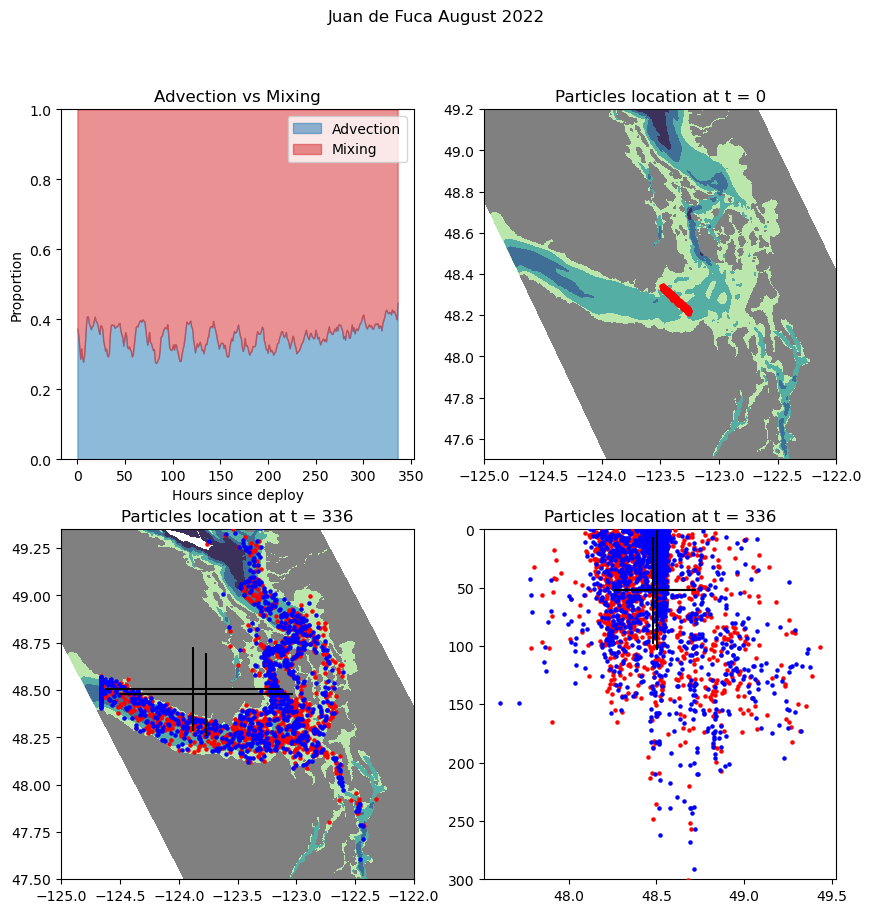

In [113]:
fig,axs=plt.subplots(2,2,figsize=(10,10))
axs[0,0].fill_between(x= T, 
        y1= pam, 
        y2=np.zeros(len(T)),
        color= "tab:blue",
        alpha= 0.5,
        label='Advection')

axs[0,0].fill_between(
        x= T, 
        y1= pam, 
        y2=np.ones(len(T)),
        color= "tab:red",
        alpha= 0.5,
        label='Mixing')
axs[0,0].legend()
axs[0,0].set_title('Advection vs Mixing')
axs[0,0].set_ylim([0,1])
axs[0,0].set_ylabel('Proportion')
axs[0,0].set_xlabel('Hours since deploy')

# Make map
blevels = list(np.arange(0,500,100))

im=axs[0,1].contourf(coords.nav_lon, coords.nav_lat, mask.totaldepth[:,:],zorder=1,cmap=cmap,levels=blevels)
axs[0,1].contourf(coords.nav_lon, coords.nav_lat, mask.umask[0,0,:,:],zorder=2,cmap='gray',levels=[-1,0])
axs[0,1].scatter(ds1.lon[:,0],ds1.lat[:,0],zorder=3,c='r',s=5)
axs[0,1].set_ylim([47.5, 49.2])
axs[0,1].set_xlim([-125,-122])
axs[0,1].set_title('Particles location at t = 0')

im=axs[1,0].contourf(coords.nav_lon, coords.nav_lat, mask.totaldepth[:,:],zorder=1,cmap=cmap,levels=blevels)
axs[1,0].contourf(coords.nav_lon, coords.nav_lat, mask.umask[0,0,:,:],zorder=2,cmap='gray',levels=[-1,0])
axs[1,0].scatter(ds1.lon[:,-1],ds1.lat[:,-1],zorder=3,c='r',s=5)
axs[1,0].set_ylim([47.5, 49.35])
axs[1,0].set_xlim([-125,-122])
axs[1,0].set_title(f'Particles location at t = {length*24}')
axs[1,0].errorbar(ds1.lon.mean(dim='trajectory')[-1], ds1.lat.mean(dim='trajectory')[-1], yerr= ds1.lat.std(dim='trajectory')[-1], xerr= ds1.lon.std(dim='trajectory')[-1],zorder=5,c='k')

axs[1,1].scatter(ds1.lat[:, -1],depth1[:, -1],zorder=3,c='r',s=5)
axs[1,1].set_ylim([300, 0])
axs[1,1].set_title(f'Particles location at t = {length*24}')
axs[1,1].errorbar(ds1.lat.mean(dim='trajectory')[-1], depth1.mean(dim='trajectory')[-1], xerr= ds1.lat.std(dim='trajectory')[-1], yerr= depth1.std(dim='trajectory')[-1],zorder=5,c='k')
plt.suptitle('Juan de Fuca August 2022')

im=axs[1,0].contourf(coords.nav_lon, coords.nav_lat, mask.totaldepth[:,:],zorder=1,cmap=cmap,levels=blevels)
axs[1,0].contourf(coords.nav_lon, coords.nav_lat, mask.umask[0,0,:,:],zorder=2,cmap='gray',levels=[-1,0])
axs[1,0].scatter(ds1_nomix.lon[:,-1],ds1_nomix.lat[:,-1], zorder=3, c='b', s=5)
axs[1,0].set_ylim([47.5, 49.35])
axs[1,0].set_xlim([-125,-122])
axs[1,0].set_title(f'Particles location at t = {length*24}')
axs[1,0].errorbar(ds1_nomix.lon.mean(dim='trajectory')[-1], ds1_nomix.lat.mean(dim='trajectory')[-1], yerr= ds1_nomix.lat.std(dim='trajectory')[-1], xerr= ds1_nomix.lon.std(dim='trajectory')[-1],zorder=5,c='k')

axs[1,1].scatter(ds1_nomix.lat[:, -1], depth1_nomix[:, -1], zorder=3, c='b', s=5)
axs[1,1].set_ylim([300, 0])
axs[1,1].set_title(f'Particles location at t = {length*24}')
axs[1,1].errorbar(ds1_nomix.lat.mean(dim='trajectory')[-1], depth1_nomix.mean(dim='trajectory')[-1], xerr= ds1_nomix.lat.std(dim='trajectory')[-1], yerr= depth1_nomix.std(dim='trajectory')[-1],zorder=5,c='k')
plt.suptitle('Juan de Fuca August 2022');


In [128]:
ds2 = xr.open_zarr(outfile)
advection = np.abs(ds2.wa)
mixing = np.abs(ds2.wm)
pm =mixing/(mixing+advection)
pa= advection/(mixing+advection)

T = np.linspace(0,length*24,int(length*24/odt))
pam = pa.mean(dim='trajectory').values

depth2 = ds2.z*ds2.fact

ds2_nomix = xr.open_zarr(outfile_nomix)
depth2_nomix = ds2_nomix.z*ds2_nomix.fact

/ocean/sallen/miniconda3/envs/py311_parcels/lib/python3.11/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))


In [ ]:
fig,axs=plt.subplots(2,2,figsize=(10,10))
axs[0,0].fill_between(x= T, 
        y1= pam, 
        y2=np.zeros(len(T)),
        color= "tab:blue",
        alpha= 0.5,
        label='Advection')

axs[0,0].fill_between(
        x= T, 
        y1= pam, 
        y2=np.ones(len(T)),
        color= "tab:red",
        alpha= 0.5,
        label='Mixing')
axs[0,0].legend()
axs[0,0].set_title('Advection vs Mixing')
axs[0,0].set_ylim([0,1])
axs[0,0].set_ylabel('Proportion')
axs[0,0].set_xlabel('Hours since deploy')


# Make map
blevels = list(np.arange(0,500,100))

im=axs[0,1].contourf(coords.nav_lon, coords.nav_lat, mask.totaldepth[:,:],zorder=1,cmap=cmap,levels=blevels)
axs[0,1].contourf(coords.nav_lon, coords.nav_lat, mask.umask[0,0,:,:],zorder=2,cmap='gray',levels=[-1,0])
axs[0,1].scatter(ds2.lon[:,0],ds2.lat[:,0],zorder=3,c='r',s=5)
axs[0,1].set_ylim([47.5,49])
axs[0,1].set_xlim([-125,-123])
axs[0,1].set_title('Particles location at t = 0')

im=axs[1,0].contourf(coords.nav_lon, coords.nav_lat, mask.totaldepth[:,:],zorder=1,cmap=cmap,levels=blevels)
axs[1,0].contourf(coords.nav_lon, coords.nav_lat, mask.umask[0,0,:,:],zorder=2,cmap='gray',levels=[-1,0])
axs[1,0].scatter(ds2.lon[:,-1],ds2.lat[:,-1],zorder=3,c='r',s=5)
axs[1,0].set_ylim([47.5,49.2])
axs[1,0].set_xlim([-125,-123])
axs[1,0].set_title(f'Particles location at t = {length*24}')
axs[1,0].errorbar(ds2.lon.mean(dim='trajectory')[-1], ds2.lat.mean(dim='trajectory')[-1], yerr= ds2.lat.std(dim='trajectory')[-1], xerr= ds2.lon.std(dim='trajectory')[-1],zorder=5,c='k')

axs[1,1].scatter(ds2.lon[:,-1],depth2[:,-1],zorder=3,c='r',s=5)
axs[1,1].set_ylim([250,0])
#axs[1,1].set_xlim([-125,-123])
axs[1,1].set_title(f'Particles location at t = {length*24}')
axs[1,1].errorbar(ds2.lon.mean(dim='trajectory')[-1], depth2.mean(dim='trajectory')[-1], xerr= ds2.lon.std(dim='trajectory')[-1], yerr= depth2.std(dim='trajectory')[-1],zorder=5,c='k')

im=axs[1,0].contourf(coords.nav_lon, coords.nav_lat, mask.totaldepth[:,:],zorder=1,cmap=cmap,levels=blevels)
axs[1,0].contourf(coords.nav_lon, coords.nav_lat, mask.umask[0,0,:,:],zorder=2,cmap='gray',levels=[-1,0])
axs[1,0].scatter(ds2_nomix.lon[:,-1],ds2_nomix.lat[:,-1],zorder=3,c='b',s=5)
axs[1,0].set_ylim([47.5, 49.2])
axs[1,0].set_xlim([-124, -122])
axs[1,0].set_title(f'Particles location at t = {length*24}')
axs[1,0].errorbar(ds2_nomix.lon.mean(dim='trajectory')[-1], ds2_nomix.lat.mean(dim='trajectory')[-1], yerr= ds2_nomix.lat.std(dim='trajectory')[-1], xerr= ds2_nomix.lon.std(dim='trajectory')[-1],zorder=5,c='k')

axs[1,1].scatter(ds2_nomix.lon[:,-1],depth2_nomix[:,-1],zorder=3,c='b',s=5)
axs[1,1].set_ylim([250,0])
#axs[1,1].set_xlim([-125,-123])
axs[1,1].set_title(f'Particles location at t = {length*24}')
axs[1,1].errorbar(ds2_nomix.lon.mean(dim='trajectory')[-1], depth2_nomix.mean(dim='trajectory')[-1], xerr= ds2_nomix.lon.std(dim='trajectory')[-1], yerr= depth2_nomix.std(dim='trajectory')[-1],zorder=5,c='k')

plt.suptitle('Haro Strait August 2022')

In [66]:
ds3 = xr.open_zarr(outfile)
advection = np.abs(ds3.wa)
mixing = np.abs(ds3.wm)
pm =mixing/(mixing+advection)
pa= advection/(mixing+advection)

T = np.linspace(0,length*24,int(length*24/odt))
pam = pa.mean(dim='trajectory').values
depth3 = ds3.z*ds3.fact

ds3_nomix = xr.open_zarr(outfile_nomix)
depth3_nomix = ds3_nomix.z*ds3_nomix.fact

/ocean/sallen/miniconda3/envs/py311_parcels/lib/python3.11/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))


In [ ]:
fig,axs=plt.subplots(2,2,figsize=(10,10))
axs[0,0].fill_between(x= T, 
        y1= pam, 
        y2=np.zeros(len(T)),
        color= "tab:blue",
        alpha= 0.5,
        label='Advection')

axs[0,0].fill_between(
        x= T, 
        y1= pam, 
        y2=np.ones(len(T)),
        color= "tab:red",
        alpha= 0.5,
        label='Mixing')
axs[0,0].legend()
axs[0,0].set_title('Advection vs Mixing')
axs[0,0].set_ylim([0,1])
axs[0,0].set_ylabel('Proportion')
axs[0,0].set_xlabel('Hours since deploy')


# Make map
blevels = list(np.arange(0,550,100))

im=axs[0,1].contourf(coords.nav_lon, coords.nav_lat, mask.totaldepth[:,:],zorder=1,cmap=cmap,levels=blevels)
axs[0,1].contourf(coords.nav_lon, coords.nav_lat, mask.umask[0,0,:,:],zorder=2,cmap='gray',levels=[-1,0])
axs[0,1].scatter(ds3.lon[:,0],ds3.lat[:,0],zorder=3,c='r',s=5)
axs[0,1].set_ylim([48.5,50])
axs[0,1].set_xlim([-124.5,-122])
axs[0,1].set_title('Particles location at t = 0')

im=axs[1,0].contourf(coords.nav_lon, coords.nav_lat, mask.totaldepth[:,:],zorder=1,cmap=cmap,levels=blevels)
axs[1,0].contourf(coords.nav_lon, coords.nav_lat, mask.umask[0,0,:,:],zorder=2,cmap='gray',levels=[-1,0])
axs[1,0].scatter(ds3.lon[:,-1],ds3.lat[:,-1],zorder=3,c='r',s=5)
axs[1,0].set_ylim([48.5,50])
axs[1,0].set_xlim([-124.5,-122])
axs[1,0].set_title(f'Particles location at t = {length*24}')
axs[1,0].errorbar(ds3.lon.mean(dim='trajectory')[-1], ds3.lat.mean(dim='trajectory')[-1], yerr= ds3.lat.std(dim='trajectory')[-1], xerr= ds3.lon.std(dim='trajectory')[-1],zorder=5,c='k')

axs[1,1].scatter(ds3.lon[:,1],depth3[:,1],zorder=3,c='r',s=5)
axs[1,1].set_ylim([250,0])
#axs[1,1].errorbar(ds3.lon.mean(dim='trajectory')[-1], depth3.mean(dim='trajectory')[-1], xerr= ds3.lon.std(dim='trajectory')[-1], yerr= depth3.std(dim='trajectory')[-1],zorder=5,c='k')
#axs[1,1].set_xlim([-125,-123])
axs[1,1].set_title(f'Particles location at t = {length*24}')

im=axs[1,0].contourf(coords.nav_lon, coords.nav_lat, mask.totaldepth[:,:],zorder=1,cmap=cmap,levels=blevels)
axs[1,0].contourf(coords.nav_lon, coords.nav_lat, mask.umask[0,0,:,:],zorder=2,cmap='gray',levels=[-1,0])
axs[1,0].scatter(ds3_nomix.lon[:,-1],ds3_nomix.lat[:,-1],zorder=3,c='b',s=5)
axs[1,0].set_title(f'Particles location at t = {length*24}')
axs[1,0].errorbar(ds3_nomix.lon.mean(dim='trajectory')[-1], ds3_nomix.lat.mean(dim='trajectory')[-1], yerr= ds3_nomix.lat.std(dim='trajectory')[-1], xerr= ds3_nomix.lon.std(dim='trajectory')[-1],zorder=5,c='k')

axs[1,1].scatter(ds3_nomix.lon[:,1],depth3_nomix[:,1],zorder=3,c='b',s=5, alpha=0.5)
axs[1,1].set_ylim([250,0])
#axs[1,1].set_xlim([-125,-123])
axs[1,1].set_title(f'Particles location at t = {length*24}')
#axs[1,1].errorbar(ds3_nomix.lon.mean(dim='trajectory')[-1], depth3_nomix.mean(dim='trajectory')[-1], xerr= ds3_nomix.lon.std(dim='trajectory')[-1], yerr= depth3_nomix.std(dim='trajectory')[-1],zorder=5,c='k')




In [ ]:
fig, axs = plt.subplots(3, 3, figsize=(10, 10))
lats1 = np.array(ds1.lat)
axs[0, 0].plot(lats1.std(axis=0), label='Full')
lats1_nm = np.array(ds1_nomix.lat)
axs[0, 0].plot(lats1_nm.std(axis=0), label='No subgrid')
axs[0, 0].text(0, 0.033, f'Missing = {int((lats1[:,-1].std()-lats1_nm[:,-1].std())/(lats1[:,-1].std()-lats1[:,0].std())*100)}%');
axs[0, 0].legend();
axs[0, 0].set_ylabel('Latitude Standard Deviation');

lons1 = np.array(ds1.lon)
axs[1, 0].plot(lons1.std(axis=0), label='Full')
lons1_nm = np.array(ds1_nomix.lon)
axs[1, 0].plot(lons1_nm.std(axis=0), label='No subgrid')
axs[1, 0].text(10, 0.075, f'Missing = {int((lons1[:,-1].std()-lons1_nm[:,-1].std())/(lons1[:,-1].std()-lons1[:,0].std())*100)}%');
axs[1, 0].set_ylabel('Longitude Standard Deviation');

depth1 = np.array(depth1)
axs[2, 0].plot(depth1.std(axis=0), label='Full')
depth1_nm = np.array(depth1_nomix)
axs[2, 0].plot(depth1_nm.std(axis=0), label='No subgrid')
axs[2, 0].text(10, 30, f'Missing = {int((depth1[:,-1].std()-depth1_nm[:,-1].std())/(depth1[:,-1].std()-depth1[:,0].std())*100)}%');
axs[2, 0].set_ylabel('Depth Standard Deviation');

lats2 = np.array(ds2.lat)
axs[0, 1].plot(lats2.std(axis=0), label='Full')
lats2_nm = np.array(ds2_nomix.lat)
axs[0, 1].plot(lats2_nm.std(axis=0), label='No subgrid')
axs[0, 1].text(10, 0.001, f'Missing = {int((lats2[:,-1].var()-lats2_nm[:,-1].var())/(lats2[:,-1].var()-lats2[:,0].var())*100)}%');

lons2 = np.array(ds2.lon)
axs[1, 1].plot(lons2.std(axis=0), label='Full')
lons2_nm = np.array(ds2_nomix.lon)
axs[1, 1].plot(lons2_nm.std(axis=0), label='No subgrid')
axs[1, 1].text(10, 0.001, f'Missing = {int((lons2[:,-1].var()-lons2_nm[:,-1].var())/(lons2[:,-1].var()-lons2[:,0].var())*100)}%');

depth2 = np.array(depth2)
axs[2, 1].plot(depth2.std(axis=0), label='Full')
depth2_nm = np.array(depth2_nomix)
axs[2, 1].plot(depth2_nm.std(axis=0), label='No subgrid')
axs[2, 1].text(0, 50, f'Missing = {int((depth2[:,-1].std()-depth2_nm[:,-1].std())/(depth2[:,-1].std()-depth2[:,0].std())*100)}%');

lats3 = np.array(ds3.lat)
axs[0, 2].plot(lats3.std(axis=0), label='Full')
lats3_nm = np.array(ds3_nomix.lat)
axs[0, 2].plot(lats3_nm.std(axis=0), label='No subgrid')
axs[0, 2].text(10, 0.003, f'Missing = {int((lats3[:,-1].var()-lats3_nm[:,-1].var())/(lats3[:,-1].var()-lats3[:,0].var())*100)}%');

lons3 = np.array(ds3.lon)
axs[1, 2].plot(lons3.std(axis=0), label='Full')
lons3_nm = np.array(ds3_nomix.lon)
axs[1, 2].plot(lons3_nm.std(axis=0), label='No subgrid')
axs[1, 2].text(5, 0.0012, f'Missing = {int((lons3[:,-1].var()-lons3_nm[:,-1].var())/(lons3[:,-1].var()-lons3[:,0].var())*100)}%');

depth3 = np.array(depth3)
axs[2, 2].plot(depth3.std(axis=0), label='Full')
depth3_nm = np.array(depth3_nomix)
axs[2, 2].plot(depth3_nm.std(axis=0), label='No subgrid')
axs[2, 2].text(10, 50, f'Missing = {int((depth3[:,-1].var()-depth3_nm[:,-1].var())/(depth3[:,-1].var()-depth3[:,0].var())*100)}%');

fig.suptitle(f'From Victoria Sill on {start}')
fig.tight_layout();

In [ ]:
print (depth1n)

In [ ]:
fig, axs = plt.subplots(3, 3, figsize=(10, 10))
lats1 = np.array(ds1.lat)
axs[0, 0].plot(lats1.mean(axis=0), label='Full')
lats1_nm = np.array(ds1_nomix.lat)
axs[0, 0].plot(lats1_nm.mean(axis=0), label='No subgrid')
axs[0, 0].text(10, 48.325, f'Difference = {int((lats1[:,-1].mean()-lats1_nm[:,-1].mean())/(lats1[:,-1].mean()-lats1[:,0].mean())*100)}%');
axs[0, 0].legend();
axs[0, 0].set_ylabel('Latitude Mean');

lons1 = np.array(ds1.lon)
axs[1, 0].plot(lons1.mean(axis=0), label='Full')
lons1_nm = np.array(ds1_nomix.lon)
axs[1, 0].plot(lons1_nm.mean(axis=0), label='No subgrid')
#axs[1, 0].text(10, 0.0022, f'Missing = {int((lons1[:,-1].var()-lons1_nm[:,-1].var())/(lons1[:,-1].var()-lons1[:,0].var())*100)}%');
#axs[1, 0].set_ylabel('Longitude Variance');

depth1n = -np.array(depth1)
axs[2, 0].plot(depth1n.mean(axis=0), label='Full')
depth1_nm = -np.array(depth1_nomix)
axs[2, 0].plot(depth1_nm.mean(axis=0), label='No subgrid')
#axs[2, 0].text(10, 1900, f'Missing = {int((depth1[:,-1].var()-depth1_nm[:,-1].var())/(depth1[:,-1].var()-depth1[:,0].var())*100)}%');
axs[2, 0].set_ylabel('Depth Variance');

lats2 = np.array(ds2.lat)
axs[0, 1].plot(lats2.mean(axis=0), label='Full')
lats2_nm = np.array(ds2_nomix.lat)
axs[0, 1].plot(lats2_nm.mean(axis=0), label='No subgrid')
axs[0, 1].text(0, 48.4, f'Difference = {int((lats2[:,-1].mean()-lats2_nm[:,-1].mean())/(lats2[:,-1].mean()-lats2[:,0].mean())*100)}%');

lons2 = np.array(ds2.lon)
axs[1, 1].plot(lons2.mean(axis=0), label='Full')
lons2_nm = np.array(ds2_nomix.lon)
axs[1, 1].plot(lons2_nm.mean(axis=0), label='No subgrid')
#axs[1, 1].text(10, 0.001, f'Missing = {int((lons2[:,-1].var()-lons2_nm[:,-1].var())/(lons2[:,-1].var()-lons2[:,0].var())*100)}%');

depth2n = -np.array(depth2)
axs[2, 1].plot(depth2n.mean(axis=0), label='Full')
depth2_nm = -np.array(depth2_nomix)
axs[2, 1].plot(depth2_nm.mean(axis=0), label='No subgrid')
#axs[2, 1].text(0, 500, f'Missing = {int((depth2[:,-1].var()-depth2_nm[:,-1].var())/(depth2[:,-1].var()-depth2[:,0].var())*100)}%');

lats3 = np.array(ds3.lat)
axs[0, 2].plot(lats3.mean(axis=0), label='Full')
lats3_nm = np.array(ds3_nomix.lat)
axs[0, 2].plot(lats3_nm.mean(axis=0), label='No subgrid')
#axs[0, 2].text(10, 0.003, f'Difference = {int((lats3[:,-1].var()-lats3_nm[:,-1].var())/(lats3[:,-1].var()-lats3[:,0].var())*100)}%');

lons3 = np.array(ds3.lon)
axs[1, 2].plot(lons3.mean(axis=0), label='Full')
lons3_nm = np.array(ds3_nomix.lon)
axs[1, 2].plot(lons3_nm.mean(axis=0), label='No subgrid')
#axs[1, 2].text(5, 0.0034, f'Missing = {int((lons3[:,-1].var()-lons3_nm[:,-1].var())/(lons3[:,-1].var()-lons3[:,0].var())*100)}%');

depth3n = -np.array(depth3)
axs[2, 2].plot(depth3n.mean(axis=0), label='Full')
depth3_nm = -np.array(depth3_nomix)
axs[2, 2].plot(depth3_nm.mean(axis=0), label='No subgrid')
#axs[2, 2].text(10, 3400, f'Missing = {int((depth3[:,-1].var()-depth3_nm[:,-1].var())/(depth3[:,-1].var()-depth3[:,0].var())*100)}%');

fig.suptitle(f'From Victoria Sill on {start}')
fig.tight_layout();

/tmp/ipykernel_5881/3161540771.py:5: RuntimeWarning: Mean of empty slice
  axs[0, 0].plot(np.nanmean(lats1, axis=0), label='Full')
/tmp/ipykernel_5881/3161540771.py:7: RuntimeWarning: Mean of empty slice
  axs[0, 0].plot(np.nanmean(lats1_nm, axis=0), label='No subgrid')
/tmp/ipykernel_5881/3161540771.py:16: RuntimeWarning: Mean of empty slice
  axs[1, 0].plot(np.nanmean(lons1, axis=0), label='Full')
/tmp/ipykernel_5881/3161540771.py:18: RuntimeWarning: Mean of empty slice
  axs[1, 0].plot(np.nanmean(lons1_nm, axis=0), label='No subgrid')
/tmp/ipykernel_5881/3161540771.py:24: RuntimeWarning: Mean of empty slice
  axs[2, 0].plot(np.nanmean(depth1n, axis=0), label='Full')
/tmp/ipykernel_5881/3161540771.py:26: RuntimeWarning: Mean of empty slice
  axs[2, 0].plot(np.nanmean(depth1_nm, axis=0), label='No subgrid')
/tmp/ipykernel_5881/3161540771.py:31: RuntimeWarning: Mean of empty slice
  axs[0, 1].plot(np.nanmean(lats2, axis=0), label='Full')
/tmp/ipykernel_5881/3161540771.py:33: RuntimeWar

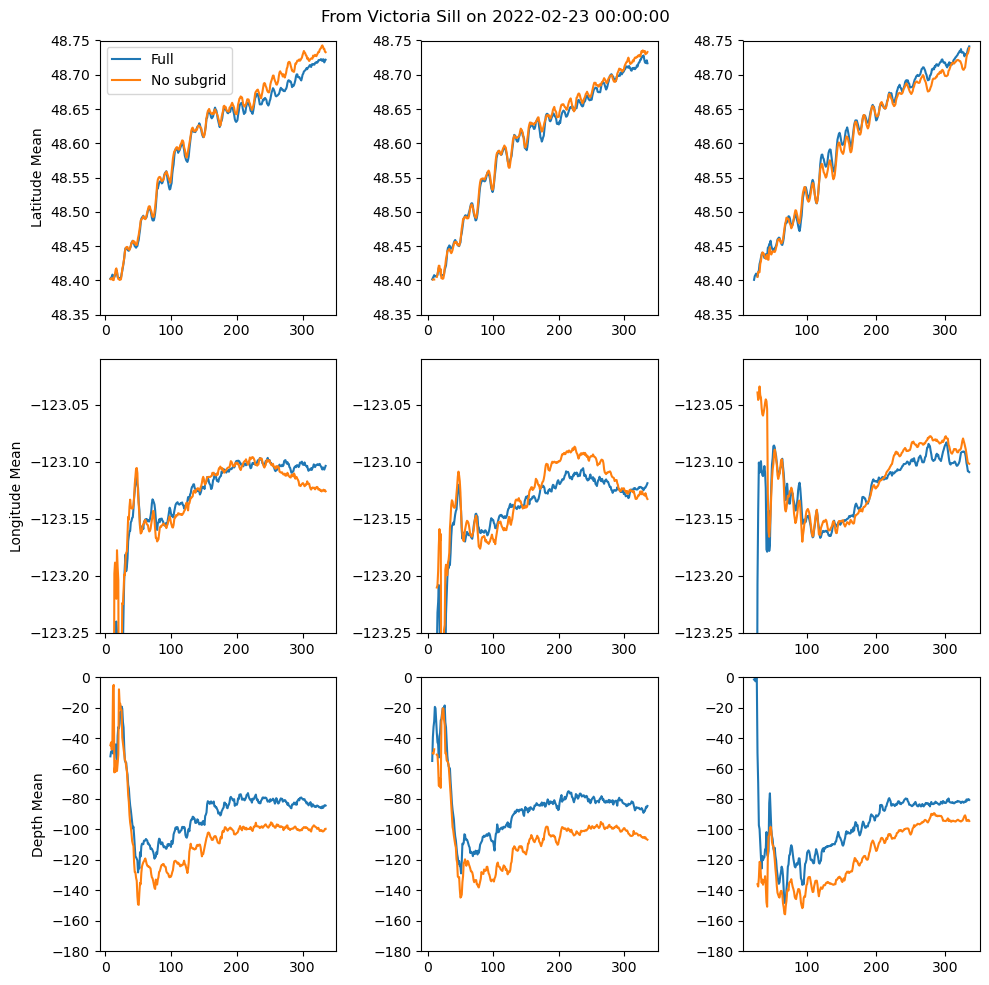

In [130]:
# North Only

fig, axs = plt.subplots(3, 3, figsize=(10, 10))
lats1 = np.array(ds1.lat.where((ds1.lat > 48.4) & (ds1.lon > -123.5)))
axs[0, 0].plot(np.nanmean(lats1, axis=0), label='Full')
lats1_nm = np.array(ds1_nomix.lat.where((ds1_nomix.lat> 48.4) & (ds1_nomix.lon > -123.5)))
axs[0, 0].plot(np.nanmean(lats1_nm, axis=0), label='No subgrid')
#print ('Lat 1', np.nanmean(lats1, axis=0)[-1], np.nanmean(lats1_nm, axis=0)[-1])
#print ('Lat 2', np.nanmean(lats2, axis=0)[-1], np.nanmean(lats2_nm, axis=0)[-1])
#print ('Lat 3', np.nanmean(lats3, axis=0)[-1], np.nanmean(lats3_nm, axis=0)[-1])

axs[0, 0].legend();
axs[0, 0].set_ylabel('Latitude Mean');

lons1 = np.array(ds1.lon.where((ds1.lat > 48.4) & (ds1.lon > -123.5)))
axs[1, 0].plot(np.nanmean(lons1, axis=0), label='Full')
lons1_nm = np.array(ds1_nomix.lon.where((ds1_nomix.lat> 48.4) & (ds1_nomix.lon > -123.5)))
axs[1, 0].plot(np.nanmean(lons1_nm, axis=0), label='No subgrid')
#print ('Lon 1', np.nanmean(lons1, axis=0)[-1], np.nanmean(lons1_nm, axis=0)[-1])
axs[1, 0].set_ylabel('Longitude Mean');


depth1n = -np.array(depth1.where((ds1.lat> 48.4) & (ds1.lon > -123.5)))
axs[2, 0].plot(np.nanmean(depth1n, axis=0), label='Full')
depth1_nm = -np.array(depth1_nomix.where((ds1_nomix.lat> 48.4) & (ds1_nomix.lon > -123.5)))
axs[2, 0].plot(np.nanmean(depth1_nm, axis=0), label='No subgrid')
#print ('depth 1', np.nanmean(depth1n, axis=0)[-1], np.nanmean(depth1_nm, axis=0)[-1])
axs[2, 0].set_ylabel('Depth Mean');

lats2 = np.array(ds2.lat.where((ds2.lat > 48.4) & (ds2.lon > -123.5)))
axs[0, 1].plot(np.nanmean(lats2, axis=0), label='Full')
lats2_nm = np.array(ds2_nomix.lat.where((ds2_nomix.lat> 48.4) & (ds2_nomix.lon > -123.5)))
axs[0, 1].plot(np.nanmean(lats2_nm, axis=0), label='No subgrid')

lons2 = np.array(ds2.lon.where((ds2.lat > 48.4) & (ds2.lon > -123.5)))
axs[1, 1].plot(np.nanmean(lons2, axis=0), label='Full')
lons2_nm = np.array(ds2_nomix.lon.where((ds2_nomix.lat> 48.4) & (ds2_nomix.lon > -123.5)))
axs[1, 1].plot(np.nanmean(lons2_nm, axis=0), label='No subgrid')

depth2n = -np.array(depth2.where((ds2.lat> 48.4) & (ds2.lon > -123.5)))
axs[2, 1].plot(np.nanmean(depth2n, axis=0), label='Full')
depth2_nm = -np.array(depth2_nomix.where((ds2_nomix.lat> 48.4) & (ds2_nomix.lon > -123.5)))
axs[2, 1].plot(np.nanmean(depth2_nm, axis=0), label='No subgrid')

lats3 = np.array(ds3.lat.where((ds3.lat > 48.4) & (ds3.lon > -123.5)))
axs[0, 2].plot(np.nanmean(lats3, axis=0), label='Full')
lats3_nm = np.array(ds3_nomix.lat.where((ds3_nomix.lat> 48.4) & (ds3_nomix.lon > -123.5)))
axs[0, 2].plot(np.nanmean(lats3_nm, axis=0), label='No subgrid')

lons3 = np.array(ds3.lon.where((ds3.lat > 48.4) & (ds3.lon > -123.5)))
axs[1, 2].plot(np.nanmean(lons3, axis=0), label='Full')
lons3_nm = np.array(ds3_nomix.lon.where((ds3_nomix.lat > 48.4) & (ds3_nomix.lon > -123.5)))
axs[1, 2].plot(np.nanmean(lons3_nm, axis=0), label='No subgrid')

depth3n = -np.array(depth3.where((ds3.lat> 48.4) & (ds3.lon > -123.5)))
axs[2, 2].plot(np.nanmean(depth3n, axis=0), label='Full')
depth3_nm = -np.array(depth3_nomix.where((ds3_nomix.lat> 48.4) & (ds3_nomix.lon > -123.5)))
axs[2, 2].plot(np.nanmean(depth3_nm, axis=0), label='No subgrid')

for ax in axs[0]:
    ax.set_ylim(48.35, 48.75)
for ax in axs[1]:
    ax.set_ylim(-123.25, -123.01)
for ax in axs[2]:
    ax.set_ylim(-180, 0)

fig.suptitle(f'From Victoria Sill on {start}')
fig.tight_layout();

/ocean/sallen/miniconda3/envs/py311_parcels/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/ocean/sallen/miniconda3/envs/py311_parcels/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/ocean/sallen/miniconda3/envs/py311_parcels/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/ocean/sallen/miniconda3/envs/py311_parcels/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/ocean/sallen/miniconda3/envs/py311_parcels/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees

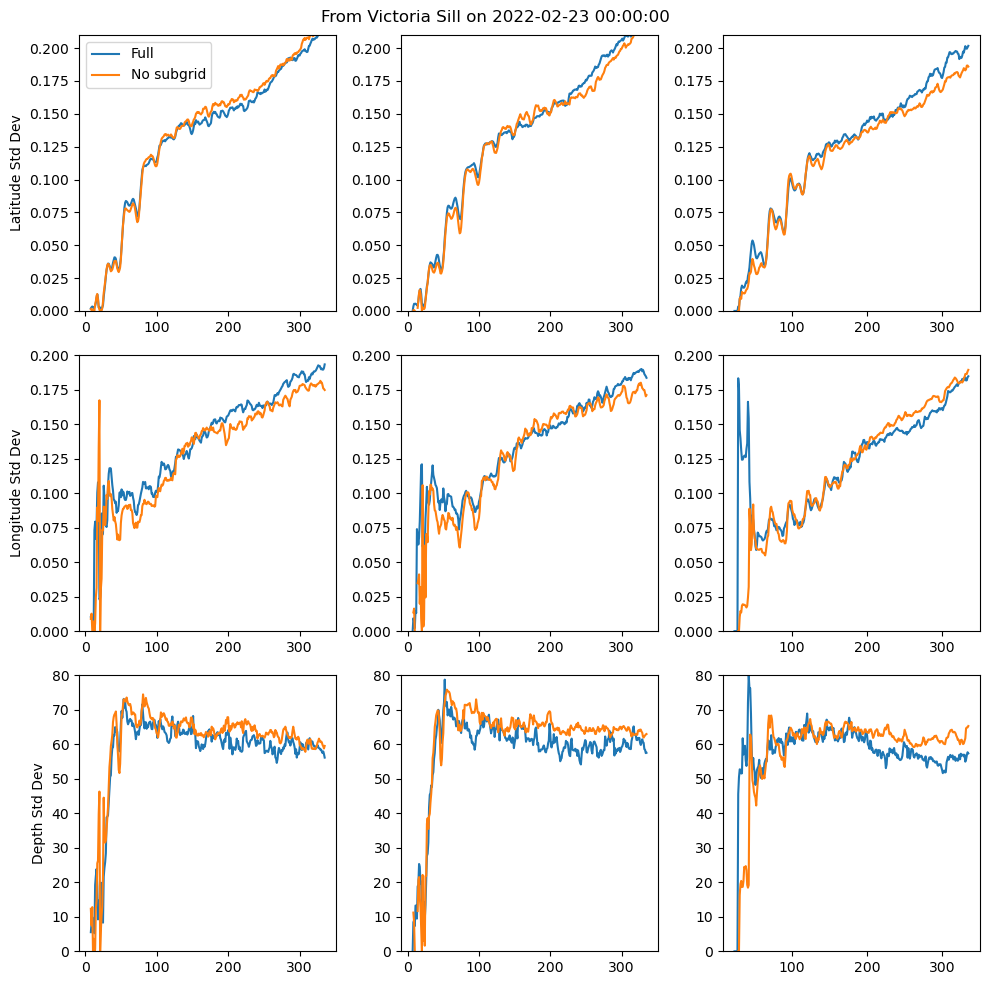

In [129]:
# North Only
fig, axs = plt.subplots(3, 3, figsize=(10, 10))
lats1 = np.array(ds1.lat.where((ds1.lat > 48.4) & (ds1.lon > -123.5)))
axs[0, 0].plot(np.nanstd(lats1, axis=0), label='Full')
lats1_nm = np.array(ds1_nomix.lat.where((ds1_nomix.lat> 48.4) & (ds1_nomix.lon > -123.5)))
axs[0, 0].plot(np.nanstd(lats1_nm, axis=0), label='No subgrid')

axs[0, 0].legend();
axs[0, 0].set_ylabel('Latitude Std Dev');

lons1 = np.array(ds1.lon.where((ds1.lat > 48.4) & (ds1.lon > -123.5)))
axs[1, 0].plot(np.nanstd(lons1, axis=0), label='Full')
lons1_nm = np.array(ds1_nomix.lon.where((ds1_nomix.lat> 48.4) & (ds1_nomix.lon > -123.5)))
axs[1, 0].plot(np.nanstd(lons1_nm, axis=0), label='No subgrid')
axs[1, 0].set_ylabel('Longitude Std Dev');

depth1n = -np.array(depth1.where((ds1.lat> 48.4) & (ds1.lon > -123.5)))
axs[2, 0].plot(np.nanstd(depth1n, axis=0), label='Full')
depth1_nm = -np.array(depth1_nomix.where((ds1_nomix.lat> 48.4) & (ds1_nomix.lon > -123.5)))
axs[2, 0].plot(np.nanstd(depth1_nm, axis=0), label='No subgrid')
axs[2, 0].set_ylabel('Depth Std Dev');

lats2 = np.array(ds2.lat.where((ds2.lat > 48.4) & (ds2.lon > -123.5)))
axs[0, 1].plot(np.nanstd(lats2, axis=0), label='Full')
lats2_nm = np.array(ds2_nomix.lat.where((ds2_nomix.lat> 48.4) & (ds2_nomix.lon > -123.5)))
axs[0, 1].plot(np.nanstd(lats2_nm, axis=0), label='No subgrid')

lons2 = np.array(ds2.lon.where((ds2.lat > 48.4) & (ds2.lon > -123.5)))
axs[1, 1].plot(np.nanstd(lons2, axis=0), label='Full')
lons2_nm = np.array(ds2_nomix.lon.where((ds2_nomix.lat> 48.4) & (ds2_nomix.lon > -123.5)))
axs[1, 1].plot(np.nanstd(lons2_nm, axis=0), label='No subgrid')

depth2n = -np.array(depth2.where((ds2.lat> 48.4) & (ds2.lon > -123.5)))
axs[2, 1].plot(np.nanstd(depth2n, axis=0), label='Full')
depth2_nm = -np.array(depth2_nomix.where((ds2_nomix.lat> 48.4) & (ds2_nomix.lon > -123.5)))
axs[2, 1].plot(np.nanstd(depth2_nm, axis=0), label='No subgrid')

lats3 = np.array(ds3.lat.where((ds3.lat > 48.4) & (ds3.lon > -123.5)))
axs[0, 2].plot(np.nanstd(lats3, axis=0), label='Full')
lats3_nm = np.array(ds3_nomix.lat.where((ds3_nomix.lat> 48.4) & (ds3_nomix.lon > -123.5)))
axs[0, 2].plot(np.nanstd(lats3_nm, axis=0), label='No subgrid')

lons3 = np.array(ds3.lon.where((ds3.lat > 48.4) & (ds3.lon > -123.5)))
axs[1, 2].plot(np.nanstd(lons3, axis=0), label='Full')
lons3_nm = np.array(ds3_nomix.lon.where((ds3_nomix.lat > 48.4) & (ds3_nomix.lon > -123.5)))
axs[1, 2].plot(np.nanstd(lons3_nm, axis=0), label='No subgrid')

depth3n = -np.array(depth3.where((ds3.lat> 48.4) & (ds3.lon > -123.5)))
axs[2, 2].plot(np.nanstd(depth3n, axis=0), label='Full')
depth3_nm = -np.array(depth3_nomix.where((ds3_nomix.lat> 48.4) & (ds3_nomix.lon > -123.5)))
axs[2, 2].plot(np.nanstd(depth3_nm, axis=0), label='No subgrid')

for ax in axs[0]:
    ax.set_ylim(0, 0.22)
for ax in axs[1]:
    ax.set_ylim(0, 0.2)
for ax in axs[2]:
    ax.set_ylim(0, 80)

fig.suptitle(f'From Victoria Sill on {start}')
fig.tight_layout();

/data/sallen/results/Test mixing vs advection20220223_1L_20220309_1L.zarr
/data/sallen/results/Test mixing vs advection20220223_2L_20220309_2L.zarr
/data/sallen/results/Test mixing vs advection20220823_1L_20220906_1L.zarr
/data/sallen/results/Test mixing vs advection20220823_2L_20220906_2L.zarr
/data/sallen/results/Test mixing vs advection20220823_3L_20220906_3L.zarr


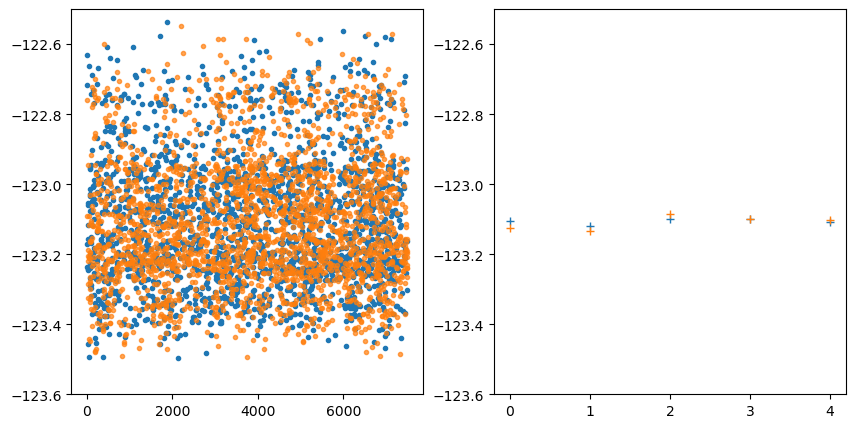

In [160]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

name = 'Test mixing vs advection'
#daterange = [start+timedelta(days=i) for i in range(length)]
#fn =  name + '_'.join(d.strftime('%Y%m%d')+'_2L' for d in [start, start+duration]) + '.zarr'
for ii, fn in enumerate(sorted(glob.glob(os.path.join(path['out'], name + '*_[123]L*')))):
    print (fn)
    data = xr.open_zarr(fn)
    axs[0].plot(range(ii*1500, 1500*(1+ii)), data.lon[:,-1].where((data.lat[:,-1] > 48.4) & (data.lon[:,-1] > -123.5)), '.', c='tab:blue')
    axs[1].plot(ii, np.nanmean(data.lon[:,-1].where((data.lat[:,-1] > 48.4) & (data.lon[:,-1] > -123.5))), '+', c='tab:blue')
    data.close()

name = 'Test only advection '
for ii, fn in enumerate(sorted(glob.glob(os.path.join(path['out'], name + '*_[123]L*')))):
    data = xr.open_zarr(fn)
    axs[0].plot(range(ii*1500, 1500*(1+ii)), data.lon[:,-1].where((data.lat[:,-1] > 48.4) & (data.lon[:,-1] > -123.5)), '.', c='tab:orange', alpha=0.7)
    axs[1].plot(ii, np.nanmean(data.lon[:,-1].where((data.lat[:,-1] > 48.4) & (data.lon[:,-1] > -123.5))), '+', c='tab:orange')

    data.close()
    



for ax in axs:
    ax.set_ylim(-123.6, -122.5)



/data/sallen/results/Test mixing vs advection20220223_1L_20220309_1L.zarr
/data/sallen/results/Test mixing vs advection20220223_2L_20220309_2L.zarr
/data/sallen/results/Test mixing vs advection20220823_1L_20220906_1L.zarr
/data/sallen/results/Test mixing vs advection20220823_2L_20220906_2L.zarr
/data/sallen/results/Test mixing vs advection20220823_3L_20220906_3L.zarr


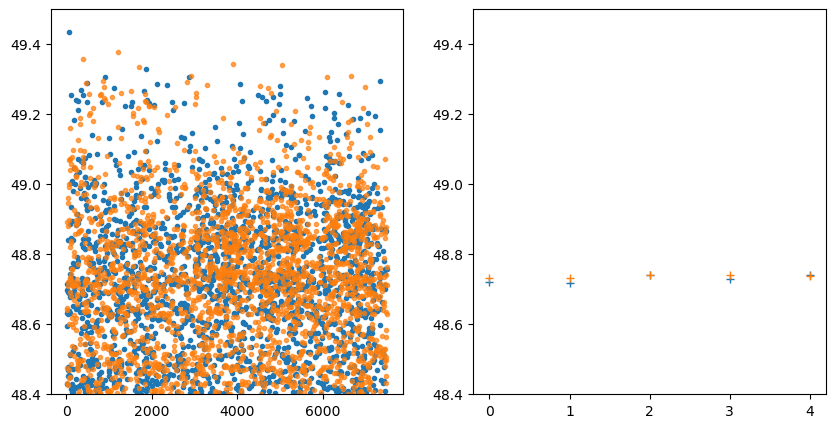

In [168]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

name = 'Test mixing vs advection'
#daterange = [start+timedelta(days=i) for i in range(length)]
#fn =  name + '_'.join(d.strftime('%Y%m%d')+'_2L' for d in [start, start+duration]) + '.zarr'
for ii, fn in enumerate(sorted(glob.glob(os.path.join(path['out'], name + '*_[123]L*')))):
    print (fn)
    data = xr.open_zarr(fn)
    axs[0].plot(range(ii*1500, 1500*(1+ii)), data.lat[:,-1].where((data.lat[:,-1] > 48.4) & (data.lon[:,-1] > -123.5)), '.', c='tab:blue')
    axs[1].plot(ii, np.nanmean(data.lat[:,-1].where((data.lat[:,-1] > 48.4) & (data.lon[:,-1] > -123.5))), '+', c='tab:blue')
    data.close()

name = 'Test only advection '
for ii, fn in enumerate(sorted(glob.glob(os.path.join(path['out'], name + '*_[123]L*')))):
    data = xr.open_zarr(fn)
    axs[0].plot(range(ii*1500, 1500*(1+ii)), data.lat[:,-1].where((data.lat[:,-1] > 48.4) & (data.lon[:,-1] > -123.5)), '.', c='tab:orange', alpha=0.7)
    axs[1].plot(ii, np.nanmean(data.lat[:,-1].where((data.lat[:,-1] > 48.4) & (data.lon[:,-1] > -123.5))), '+', c='tab:orange')

    data.close()
    



for ax in axs:
    ax.set_ylim(48.4, 49.5)

/data/sallen/results/Test mixing vs advection20220223_1L_20220309_1L.zarr
/data/sallen/results/Test mixing vs advection20220223_2L_20220309_2L.zarr
/data/sallen/results/Test mixing vs advection20220823_1L_20220906_1L.zarr
/data/sallen/results/Test mixing vs advection20220823_2L_20220906_2L.zarr
/data/sallen/results/Test mixing vs advection20220823_3L_20220906_3L.zarr


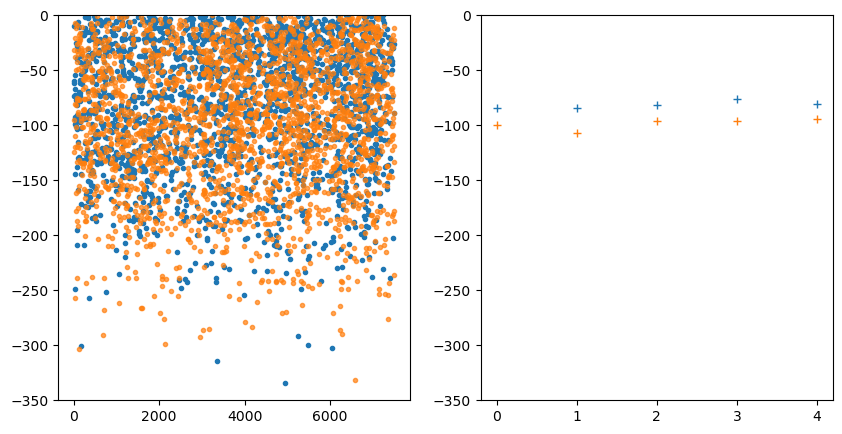

In [165]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

name = 'Test mixing vs advection'
#daterange = [start+timedelta(days=i) for i in range(length)]
#fn =  name + '_'.join(d.strftime('%Y%m%d')+'_2L' for d in [start, start+duration]) + '.zarr'
for ii, fn in enumerate(sorted(glob.glob(os.path.join(path['out'], name + '*_[123]L*')))):
    print (fn)
    data = xr.open_zarr(fn)
    axs[0].plot(range(ii*1500, 1500*(1+ii)), (-data.z[:,-1]*data.fact[:,-1]).where((data.lat[:,-1] > 48.4) & (data.lon[:,-1] > -123.5)), '.', c='tab:blue')
    axs[1].plot(ii, np.nanmean((-data.z[:,-1]*data.fact[:,-1]).where((data.lat[:,-1] > 48.4) & (data.lon[:,-1] > -123.5))), '+', c='tab:blue')
    data.close()

name = 'Test only advection '
for ii, fn in enumerate(sorted(glob.glob(os.path.join(path['out'], name + '*_[123]L*')))):
    data = xr.open_zarr(fn)
    axs[0].plot(range(ii*1500, 1500*(1+ii)), (-data.z[:,-1]*data.fact[:,-1]).where((data.lat[:,-1] > 48.4) & (data.lon[:,-1] > -123.5)), '.', c='tab:orange', alpha=0.7)
    axs[1].plot(ii, np.nanmean((-data.z[:,-1]*data.fact[:,-1]).where((data.lat[:,-1] > 48.4) & (data.lon[:,-1] > -123.5))), '+', c='tab:orange')

    data.close()
    
depth3_nomix = ds3_nomix.z*ds3_nomix.fact


for ax in axs:
    ax.set_ylim(-350, 0)

